In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.models import load_model
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import keras.backend as K
from keras.layers.core import Lambda
import tensorflow as tf
import keras
import cv2

In [2]:
traindata_size = 100000

In [3]:
def target_category_loss(x, category_index, nb_classes):
    error_loss = tf.subtract(x, nb_classes)
    return tf.square(error_loss)

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def grad_cam(input_model, value, real_value,layer_name):
    
    target_layer = lambda x: target_category_loss(x, value, real_value)

    x = input_model.layers[-1].output
    x = Lambda(target_layer, output_shape=target_category_loss_output_shape)(x)
    model = keras.models.Model(input_model.layers[0].input, x)

    loss = K.sum(model.layers[-1].output)
    conv_output = [l for l in model.layers if l.name == layer_name][0].output
    
    g = tf.Graph()
    with g.as_default():
        grads = tf.gradients(loss, conv_output)[0]
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])
    #output.shape=(1,*,128)
    output, grads_val = gradient_function([value])
    output, grads_val = output[0, :, :], grads_val[0, :, :]
    #output.shape=(*,128)
    weights = np.mean(grads_val, axis = 0)
    cam = np.zeros(output.shape[0], dtype = np.float32)
    
    for i, w in enumerate(weights):
        cam += w * output[:, i]
        
    cam = cam.reshape([cam.shape[0], 1])
    
    cam = cv2.resize(cam, (1,traindata_size))
    cam = np.maximum(cam, 0)
    
    heatmap = (cam - np.min(cam))/(np.max(cam) - np.min(cam))
    heatmap = heatmap.reshape([cam.shape[0]])
    
    return heatmap

In [5]:

npz_kw = np.load('../my_model_data.npz')
x_train = npz_kw['x_train']
y_train = npz_kw['y_train']
x_test = npz_kw['x_test']
y_test = npz_kw['y_test']

model = load_model('../model_params/my_model.h5')


In [6]:
#learning = model.fit(x_train, y_train, epochs=300, validation_data = (x_test,y_test))

0.6771063879381098


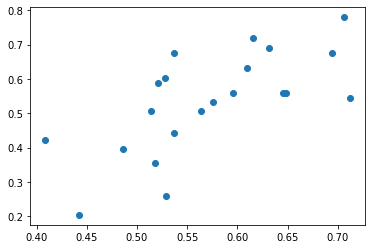

In [7]:
result = model.predict(npz_kw['x_test']).flatten()
plt.scatter(result, y_test)
cov = np.corrcoef(result, y_test)
print(cov[0][1])

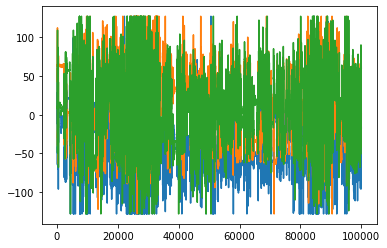

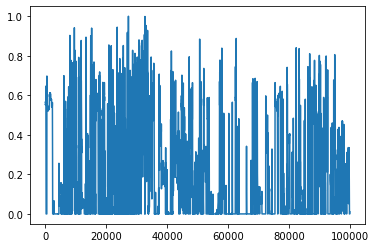

In [8]:

NNN=0
predict_data = np.array([x_test[NNN]])
predictions = model.predict(predict_data)
heatmap = grad_cam(model, predict_data, y_test[NNN], 'conv1d_41')

plt.plot(x_test[NNN])
plt.show()
plt.plot(heatmap)
plt.show()

In [9]:
x_test.shape

(21, 100000, 3)

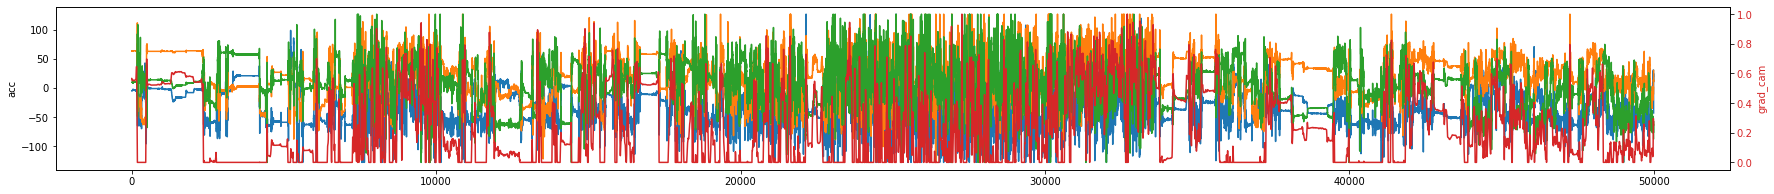

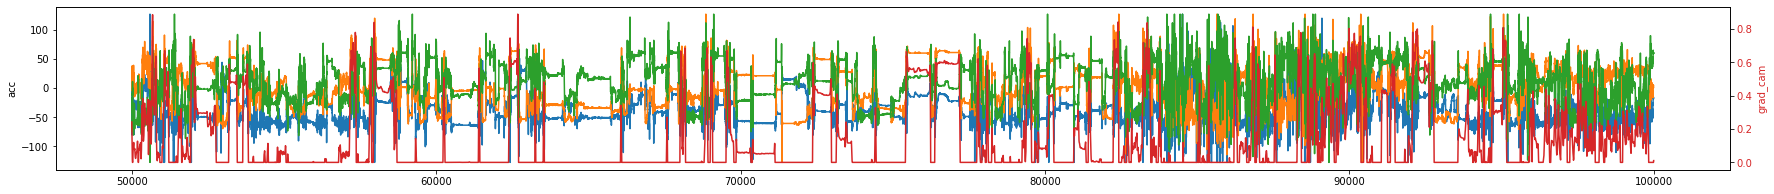

In [10]:
x = range(100000)
fig, ax1 = plt.subplots(figsize=(30,3))

ax1.set_ylabel('acc')
ax1.plot(x[:50000], x_test[0, :50000])
#1->orange, 0-> blue, 2->green
ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('grad_cam', color = color)
ax2.plot(heatmap[:50000], color = color)
ax2.tick_params(axis='y', labelcolor = color)

plt.show()

fig, ax1 = plt.subplots(figsize=(30,3))

ax1.set_ylabel('acc')
ax1.plot(x[50000:], x_test[0][50000:])

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('grad_cam', color = color)
ax2.plot(x[50000:], heatmap[50000:], color = color)
ax2.tick_params(axis='y', labelcolor = color)

plt.show()

In [78]:
def index_list(heatmapdata, threshold1):
    (upper_index,) = np.where(heatmapdata >= threshold1)
#    print(upper_index)
    storage = []
    for i, w in enumerate(upper_index):
        if i==0:
            storage += [[upper_index[0],upper_index[0]+1]]
        else:
            [left ,right] = storage[-1]
            if w==right:
                storage[-1]=[left,right+1]
            else:
                storage += [[w,w+1]]
#    print(storage)
    return storage

96 135
151 161
177 223
351 355
403 415
662 674
727 795
857 911
994 1321
1379 1428
1489 1513
1584 1588
1596 1643
1653 1730
1774 1819
1838 1862
1883 1939
1975 1988
2017 2019
2059 2257
2267 2436
2444 2506
2514 2600
2689 2711
2746 2835
2837 2861
2874 2989
2992 3029
3090 3203
3252 3385
3463 3496
3505 3664
3676 3703
3730 3761
4206 4230
4639 4742
4766 4785
4857 4907
5132 5193
5586 5716
7294 7302
7376 7418
7569 7597
7599 7626
11203 11258
11366 11419
11852 11891
11893 11902
11922 11940
11956 11976
12098 12151
12254 12266
12299 12388
12425 12464
12470 12499
12718 12777
13698 13702
14668 14797
14798 14809
14837 14864
14932 14933
15062 15070
15289 15317
15372 15377
15408 15412
15640 15655
17234 17261
17816 17838
17916 18004
18063 18066
18222 18261
18275 18332


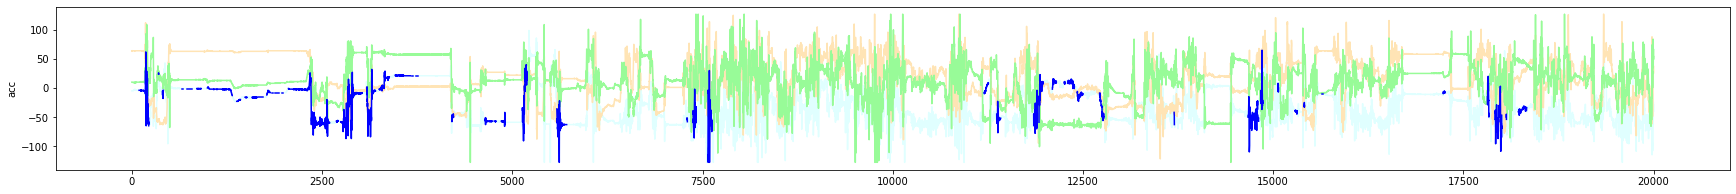

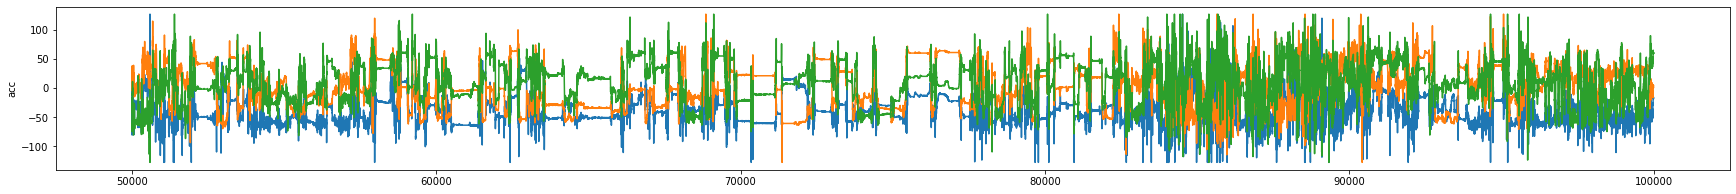

In [87]:
threshold = 0.5

x = np.arange(100000)


fig, ax1 = plt.subplots(figsize=(30,3))

ax1.set_ylabel('acc')
ax1.plot(x[:20000], x_test[0, :20000, 0], color='lightcyan')
ax1.plot(x[:20000], x_test[0, :20000, 1], color='moccasin')
ax1.plot(x[:20000], x_test[0, :20000, 2], color='palegreen')
#1->orange, 0-> blue, 2->green
for [left,right] in index_list(heatmap[30000:50000], threshold):
    print(left,right)
    ax1.plot(x[left:right], x_test[0, left:right, 0], color='blue')
plt.show()

fig, ax1 = plt.subplots(figsize=(30,3))

ax1.set_ylabel('acc')
ax1.plot(x[50000:], x_test[0][50000:])

plt.show()

In [78]:
model.save('../model_params/my_model.h5')
model.save_weights('../model_params/my_model_weights.h5')